In [2]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

## 1) Loading in the data

In [3]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','NOX','O3','PM2_5'])#
one_feature.head(5)

,Start,NO2,PM10
0,2015-01-01 00:00:00,4.5,28.4
1,2015-01-01 01:00:00,3.1,8.5
2,2015-01-01 02:00:00,2.1,8.7
3,2015-01-01 03:00:00,1.6,10.5
4,2015-01-01 04:00:00,1.4,12.1


## 2) Creating the train and testing set

In [4]:
one_feature.loc[(one_feature['PM10'] <= 0, 'PM10')]=np.nan
one_feature.loc[(one_feature['NO2'] <= 0, 'PM10')]=np.nan

In [49]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down=one_feature.copy()
scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))

In [50]:
train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]

### Training set

In [37]:
training_set=train['PM10']
X_train = []
y_train = []
for i in range(5, len(training_set)):
    X_train.append(training_set.loc[i-5:i])
    y_train.append(training_set.loc[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print (X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_train)):
    if np.isnan(X_train[i]).any() or np.isnan(y_train[i]):
        index.append(i)
X_train_new=np.delete(X_train,index, axis=0)
y_train_new=np.delete(y_train,index)

(35059, 6)


### Testing set

In [51]:
testing_set=test['PM10']
testing_set=testing_set.reset_index()
testing_set=testing_set['PM10']
X_test = []
y_test = []
for i in range(5, len(testing_set)):
    X_test.append(testing_set[i-5:i])
    y_test.append(testing_set[i])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print (X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_test)):
    if np.isnan(X_test[i]).any() or np.isnan(y_test[i]):
        index.append(i)
X_test_new=np.delete(X_test,index, axis=0)
y_test_new=np.delete(y_test,index)

(8755, 5)


## 3) Model creation 

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train_new, y_train_new, epochs = 15, batch_size = 32)

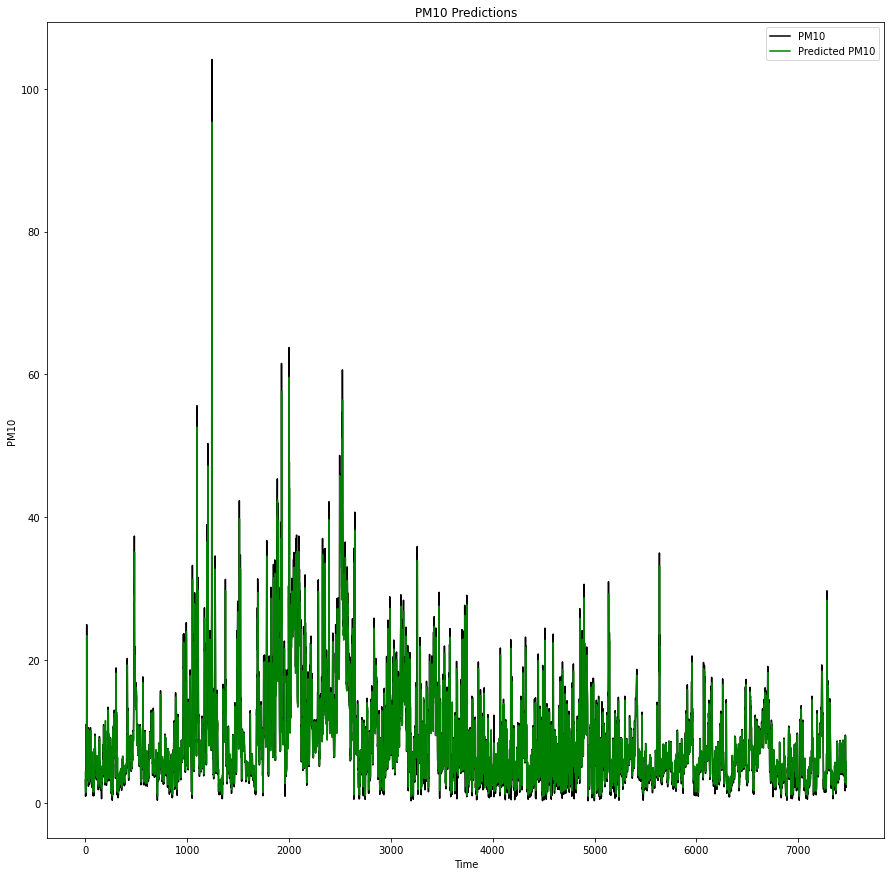

In [9]:
predicted = regressor.predict(X_test_new)
predicted=sc.inverse_transform(predicted)
y_test_new=sc.inverse_transform(y_test_new.reshape(-1,1))
fig = plt.figure(figsize=(15,15))
plt.plot(y_test_new, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test_new, predicted))
print(rmse)

3.2153575467816538


In [187]:
from sklearn.metrics import mean_squared_error
predicted = regressor.predict(X_train_new)
predicted=sc.inverse_transform(predicted)
y_train_new=sc.inverse_transform(y_train_new.reshape(-1,1))
import math
rmse = math.sqrt(mean_squared_error(y_train_new, predicted))
print(rmse)


0.5073876300089184


# MODEL CREATION v2 

### UNIVARIATE MODEL

In [43]:
temp_train=one_feature[(one_feature['Start']<= "2018-12-31 23:00:00")]
temp_test=one_feature[(one_feature['Start']>= "2019-12-30 00:00:00")]
temp_train=temp_train.drop('NO2',axis=1)
temp_test=temp_test.drop('NO2',axis=1)

#### Training

In [44]:
from keras.preprocessing.sequence import TimeseriesGenerator
temp = temp_train.copy()
temp=temp.fillna(0)
temp=temp.drop('Start', axis = 1)
temp_X_train = temp
temp_X_train = temp_X_train.values
temp_X_train = temp_X_train.reshape(len(temp_X_train))
# temp_y_train = temp[['PM10']].copy() 
# temp_y_train = temp_y_train.values
# temp_y_train = temp_y_train.reshape(-1) 
# temp_y_train = np.insert(temp_y_train, 0, 0)
# temp_y_train = np.delete(temp_y_train, -1)
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= 1 # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator_train = TimeseriesGenerator(temp_X_train, temp_X_train, length=n_input, batch_size=b_size)

print(generator_train[0][0].shape)

(32, 5)


#### Testing

In [45]:
from keras.preprocessing.sequence import TimeseriesGenerator
temp = temp_test.copy()
temp=temp.fillna(0)
temp=temp.drop('Start', axis = 1)
temp_X_test = temp
temp_X_test = temp_X_test.values
temp_X_test = temp_X_test.reshape(len(temp_X_test))
# temp_y_test = temp[['PM10']].copy().values
# temp_y_test=temp_y_test.reshape(len(temp_y_test)) 
# temp_y_test = temp_y_test.values
# temp_y_test = temp_y_test.reshape(-1) 
# temp_y_test = np.insert(temp_y_test, 0, 0)
# temp_y_test = np.delete(temp_y_test, -1)
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
# n_features= temp_X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator_test = TimeseriesGenerator(temp_X_test, temp_X_test, length=n_input, batch_size=b_size)

print(generator_test[0][0].shape)

(32, 5)


In [46]:
from keras.layers import Masking
model = Sequential()
model.add(Masking(mask_value=0.,input_shape=(n_input, n_features)))      
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 5, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit_generator(generator_train,epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1096/1096 [==============================] - 2s 2ms/step - loss: 26.8652
Epoch 2/5
1096/1096 [==============================] - 2s 2ms/step - loss: 24.8212
Epoch 3/5
1096/1096 [==============================] - 2s 2ms/step - loss: 24.2406
Epoch 4/5
1096/1096 [==============================] - 2s 2ms/step - loss: 23.9671
Epoch 5/5
1096/1096 [==============================] - 2s 2ms/step - loss: 24.1734


In [52]:
import numpy.ma as ma
predicted = model.predict(generator_test)
fig = plt.figure(figsize=(15,15))
plt.plot(temp_y_test, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

NameError: name 'temp_y_test' is not defined

<Figure size 1080x1080 with 0 Axes>

### MULTIVARIATE

#### Loading the data

In [36]:
multivariate=airQualityData.drop(columns=['Black Carbon','NOX','O3','PM2_5'])

multivariate.loc[(multivariate['PM10'] <= 0, 'PM10')]=np.nan
multivariate.loc[(multivariate['NO2'] <= 0, 'PM10')]=np.nan

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down_multi=multivariate.copy()
scaled_down_multi['PM10']=sc.fit_transform(scaled_down_multi['PM10'].values.reshape(-1, 1))
scaled_down_multi['NO2']=sc.fit_transform(scaled_down_multi['NO2'].values.reshape(-1, 1))


temp_train=scaled_down_multi[(scaled_down_multi['Start']<= "2018-12-31 23:00:00")]
temp_test=scaled_down_multi[(scaled_down_multi['Start']>= "2019-12-01 00:00:00")]

#### Setting up the training and testing data

In [37]:
from keras.preprocessing.sequence import TimeseriesGenerator
temp = temp_train.copy()
temp=temp.fillna(0)
temp=temp.drop('Start', axis = 1)
temp_X_train = temp.values
temp_Y_train = temp['PM10'].values
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= temp_X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator_train = TimeseriesGenerator(temp_X_train, temp_Y_train, length=n_input, batch_size=b_size)
print(generator_train[0][0].shape)

(32, 5, 2)


##### testing


In [38]:
testing_set = temp_test.copy()
testing_set=testing_set.fillna(0)
testing_set=testing_set.drop('Start', axis = 1)
testing_set=testing_set.reset_index()
testing_set=testing_set.drop('index', axis = 1)

X_test = []
y_test = []
for i in range(5, len(testing_set)):
    X_test.append(testing_set.values[i-5:i])
    y_test.append(testing_set['PM10'].values[i])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print (X_test.shape)

(739, 5, 2)


#### Model creation

In [39]:
from keras.layers import Masking
model = Sequential()
model.add(Masking(mask_value=0.,input_shape=(n_input, n_features)))      

model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 150, return_sequences = False))
model.add(Dropout(0.2))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 5, 2)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 150)            91800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 150)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 272,551
Trainable params: 272,551
Non-trainable params: 0
________________________________________________

#### Training process

In [40]:
model.fit(generator_train,epochs=5)

Epoch 1/5
1096/1096 [==============================] - 7s 6ms/step - loss: 0.0012
Epoch 2/5
1096/1096 [==============================] - 7s 6ms/step - loss: 9.2916e-04
Epoch 3/5
1096/1096 [==============================] - 7s 6ms/step - loss: 8.9913e-04
Epoch 4/5
1096/1096 [==============================] - 7s 6ms/step - loss: 9.0401e-04
Epoch 5/5
1096/1096 [==============================] - 7s 6ms/step - loss: 8.8848e-04


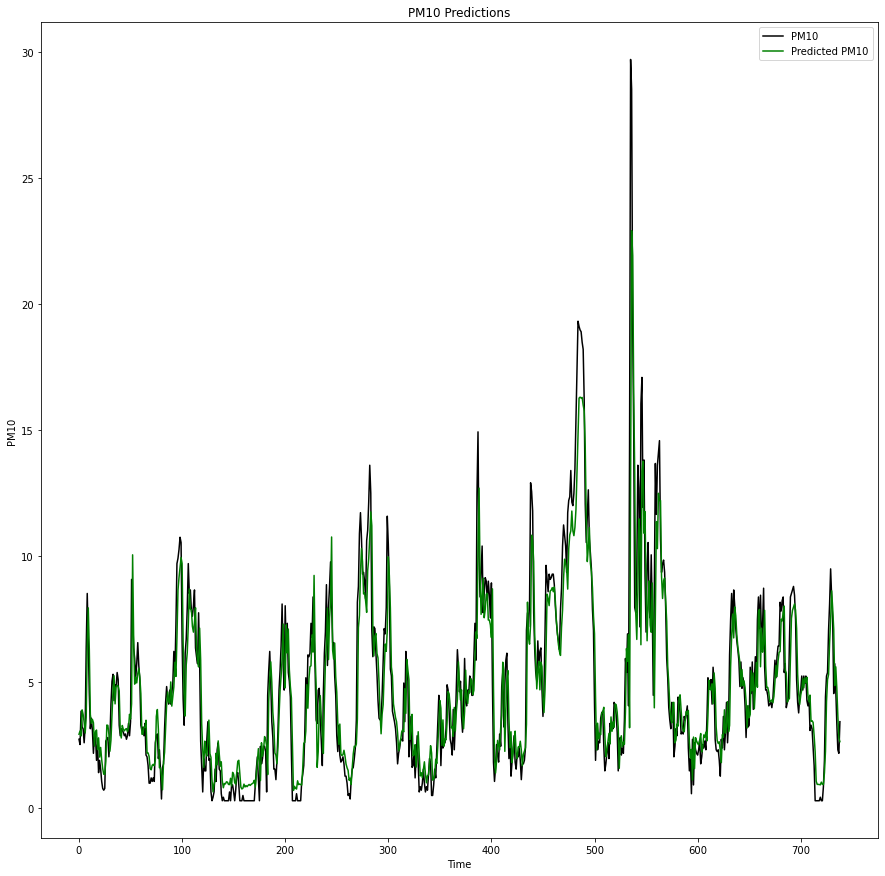

5.666493160467306


In [41]:
import numpy.ma as ma
# testing_set = temp_test.copy()
# testing_set=testing_set.fillna(0)
# testing_set=testing_set.drop('Start', axis = 1)
# a=testing_set[['PM10','NO2']].values.ravel()
# a=a[:740]
# a=a.reshape(-1,5,2)
predicted = model.predict(X_test)
predicted=sc.inverse_transform(predicted)
y_test_descaled=sc.inverse_transform(y_test.reshape(-1,1))
fig = plt.figure(figsize=(15,15))
plt.plot(y_test_descaled, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test, predicted))
print(rmse)

# EXperimental

In [13]:
import datetime

dt = datetime.datetime(2015, 12, 1)
end = datetime.datetime(2018, 12, 30, 23, 59, 59)
step = datetime.timedelta(weeks=4)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
    dt += step

In [96]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Masking
from math import sqrt
from sklearn.metrics import mean_squared_error
multivariate=airQualityData.drop(columns=['Black Carbon','NOX','O3','PM2_5'])

multivariate.loc[(multivariate['PM10'] <= 0, 'PM10')]=np.nan
multivariate.loc[(multivariate['NO2'] <= 0, 'PM10')]=np.nan

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down_multi=multivariate.copy()
scaled_down_multi['PM10']=sc.fit_transform(scaled_down_multi['PM10'].values.reshape(-1, 1))
scaled_down_multi['NO2']=sc.fit_transform(scaled_down_multi['NO2'].values.reshape(-1, 1))

train_results=[]
test_results=[]
for i in result:
    temp_train=scaled_down_multi[(scaled_down_multi['Start']<= i)]
    temp_test=scaled_down_multi[(scaled_down_multi['Start']>= "2019-12-01 00:00:00")]  
    temp = temp_train.copy()
    temp=temp.fillna(0)
    temp=temp.drop('Start', axis = 1)
    temp_X_train = temp.values
    temp_Y_train = temp['PM10'].values
    n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
    n_features= temp_X_train.shape[1] # how many predictors/Xs/features we have to predict y
    b_size = 32 # Number of timeseries samples in each batch
    generator_train = TimeseriesGenerator(temp_X_train, temp_Y_train, length=n_input, batch_size=b_size)
    print(generator_train[0][0].shape)
    testing_set = temp_test.copy()
    testing_set=testing_set.fillna(0)
    testing_set=testing_set.drop('Start', axis = 1)
    testing_set=testing_set.reset_index()
    testing_set=testing_set.drop('index', axis = 1)

    X_test = []
    y_test = []
    for i in range(5, len(testing_set)):
        X_test.append(testing_set.values[i-5:i])
        y_test.append(testing_set['PM10'].values[i])

    X_test, y_test = np.array(X_test), np.array(y_test)
    print (X_test.shape)
    
    training_set=temp_train.copy()
    training_set=training_set.fillna(0)
    training_set=training_set.drop('Start', axis = 1)
    training_set=training_set.reset_index()
    training_set=training_set.drop('index', axis = 1)
    X_train_error = []
    y_train_error = []
    for i in range(5, len(training_set)):
        X_train_error.append(training_set.values[i-5:i])
        y_train_error.append(training_set['PM10'].values[i])

    X_train_error, y_train_error = np.array(X_train_error), np.array(y_train_error)
    print (X_train_error.shape)
    model = Sequential()
    model.add(Masking(mask_value=0.,input_shape=(n_input, n_features)))      

    model.add(LSTM(units = 150, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 150, return_sequences = False))
    model.add(Dropout(0.2))


    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(generator_train,epochs=5)
    test_results.append( sqrt(mean_squared_error(y_test, model.predict(X_test))))
    train_results.append(sqrt(mean_squared_error(y_train_error,model.predict(X_train_error))))

(32, 5, 2)
(739, 5, 2)
(8012, 5, 2)
Epoch 1/5
251/251 [==============================] - 3s 13ms/step - loss: 0.0015
Epoch 2/5
251/251 [==============================] - 3s 12ms/step - loss: 0.0011
Epoch 3/5
251/251 [==============================] - 3s 13ms/step - loss: 8.9318e-04
Epoch 4/5
251/251 [==============================] - 3s 12ms/step - loss: 8.5234e-04
Epoch 5/5
251/251 [==============================] - 3s 12ms/step - loss: 8.4350e-04
(32, 5, 2)
(739, 5, 2)
(8684, 5, 2)
Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 0.0014
Epoch 2/5
272/272 [==============================] - 3s 12ms/step - loss: 0.0010
Epoch 3/5
272/272 [==============================] - 3s 12ms/step - loss: 8.5179e-04
Epoch 4/5
272/272 [==============================] - 3s 12ms/step - loss: 8.5315e-04
Epoch 5/5
272/272 [==============================] - 3s 13ms/step - loss: 8.2181e-04
(32, 5, 2)
(739, 5, 2)
(9356, 5, 2)
Epoch 1/5
293/293 [==============================] - 4s 12

986/986 [==============================] - 12s 12ms/step - loss: 9.5185e-04
Epoch 4/5
986/986 [==============================] - 12s 12ms/step - loss: 9.4620e-04
Epoch 5/5
986/986 [==============================] - 12s 12ms/step - loss: 9.5098e-04
(32, 5, 2)
(739, 5, 2)
(32204, 5, 2)
Epoch 1/5
1007/1007 [==============================] - 13s 13ms/step - loss: 0.0012
Epoch 2/5
1007/1007 [==============================] - 13s 13ms/step - loss: 9.6709e-04
Epoch 3/5
1007/1007 [==============================] - 13s 12ms/step - loss: 9.6012e-04
Epoch 4/5
1007/1007 [==============================] - 13s 13ms/step - loss: 9.5759e-04
Epoch 5/5
1007/1007 [==============================] - 13s 13ms/step - loss: 9.4996e-04
(32, 5, 2)
(739, 5, 2)
(32876, 5, 2)
Epoch 1/5
1028/1028 [==============================] - 13s 12ms/step - loss: 0.0012
Epoch 2/5
1028/1028 [==============================] - 13s 12ms/step - loss: 9.6458e-04
Epoch 3/5
1028/1028 [==============================] - 13s 12ms/step -

In [92]:
np.array(train_results).shape


(41,)

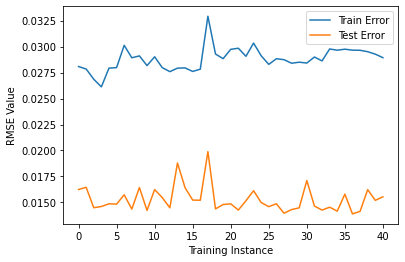

In [98]:
# Plot 
plt.plot(train_results,label="Train Error")
plt.plot(test_results,label="Test Error")
plt.xlabel('Training Instance')
plt.ylabel('RMSE Value')
plt.legend()
plt.show()

In [97]:
train_results

[0.028077904995260222,
 0.027837815550167698,
 0.026856676576948957,
 0.026121850047285185,
 0.027923887930688722,
 0.02797397005697031,
 0.03011787904094706,
 0.02891924072826006,
 0.02910173048823899,
 0.028167828566073656,
 0.029016494477350843,
 0.027972685083210883,
 0.02758541572566929,
 0.027921545877497036,
 0.02794560195069307,
 0.0276054950496218,
 0.027823975999761393,
 0.0329157649478785,
 0.029280186300481514,
 0.028834517451969344,
 0.029732621029264744,
 0.029839349265378737,
 0.02906234511127658,
 0.030332761521013874,
 0.02911655101733439,
 0.028284894144163183,
 0.02882909070989296,
 0.028736560733387612,
 0.028396003808173108,
 0.02849390072362955,
 0.028413643862688766,
 0.028992613318085857,
 0.028619070784522423,
 0.02976717629824785,
 0.029647858413036906,
 0.02974514683295616,
 0.02965240271248518,
 0.029641183880680717,
 0.029503414617456,
 0.029268960633581413,
 0.02892982024553145]